In [3]:
import os
from datetime import datetime as dt
import math

import netCDF4
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML

from scipy import ndimage
from skimage import morphology, measure, feature, draw
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import networkx as nx


In [4]:
## config

#paths
input_path  = '/g/data/kl02/jss548/bonn-project-data/radolan_data/radolan_nc'
output_path = '/g/data/kl02/jss548/bonn-project-data/radolan_png'

#data values
bad         = np.nan
min_value   = -32.5
pad_value   = np.floor(min_value/5)*5

#dimension limit in x
x_start     = 145 #values in x dim less this this aren't present

#file/volume
input_fn    = 'RX-2013-08-06.nc'
vol_idx    = 200

#filter config
n_parm     = 3
g1_size    = 2*n_parm + 1
g2_size    = 4*n_parm + 3
min_refl   = 0.
max_refl   = 35.
min_length = 15.

#convolutions
n5_window = np.array([[1,1,1,1,1],
                    [1,0,0,0,1],
                    [1,0,0,0,1],
                    [1,0,0,0,1],
                    [1,1,1,1,1]])
n3_window = np.array([[1,1,1],
                    [1,0,1],
                    [1,1,1]])


In [1]:
#calculate convolutions
def refl_to_int(ref):
    return np.floor(ref.copy()/5)*5

#distance in pixel coordinates
def distance(a, b):
    return  math.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)

def lbp_filter(x):
    """
    Local Binary Pattern Filter
    Counts number of changes from 0 to 1 in x
    """
    #wrap 1D array
    wrap_x   = np.append(x[-1], x)
    #use abs of diff to find changes
    change_x = np.abs(wrap_x[1:] - wrap_x[:-1])
    #sum changes
    change_count = np.sum(change_x)
    return change_count

#generate points
def point_line_distance(point, start, end):
    if (start == end):
        return distance(point, start)
    else:
        n = abs(
            (end[0] - start[0]) * (start[1] - point[1]) - (start[0] - point[0]) * (end[1] - start[1])
        )
        d = math.sqrt(
            (end[0] - start[0]) ** 2 + (end[1] - start[1]) ** 2
        )
        return n / d

#simplify skeleton
def rdp(points, epsilon):
    """
    Reduces a series of points to a simplified version that loses detail, but
    maintains the general shape of the series.
    http://en.wikipedia.org/wiki/Ramer-Douglas-Peucker_algorithm
    https://github.com/sebleier/RDP/blob/master/__init__.py
    """
    dmax = 0.0
    index = 0
    for i in range(1, len(points) - 1):
        d = point_line_distance(points[i], points[0], points[-1])
        if d > dmax:
            index = i
            dmax = d
    if dmax >= epsilon:
        results = rdp(points[:index+1], epsilon)[:-1] + rdp(points[index:], epsilon)
    else:
        results = [points[0], points[-1]]
    return results

def vector_pair_angle(vector_list):
    """
    Returns the angles between vectors.

    https://stackoverflow.com/questions/14631776/calculate-turning-points-pivot-points-in-trajectory-path

    Parameters:
    dir is a 2D-array of shape (N,M) representing N vectors in M-dimensional space.

    The return value is a 1D-array of values of shape (N-1,), with each value
    between 0 and pi.

    0 implies the vectors point in the same direction
    pi/2 implies the vectors are orthogonal
    pi implies the vectors point in opposite directions
    """
    dir2 = vector_list[1:]
    dir1 = vector_list[:-1]
    return np.arccos((dir1*dir2).sum(axis=1)/(
        np.sqrt((dir1**2).sum(axis=1)*(dir2**2).sum(axis=1))))

def order_points(points):
    """
    https://stackoverflow.com/questions/37742358/sorting-points-to-form-a-continuous-line
    """
    
    clf = NearestNeighbors(2).fit(points) #calc nearest neighbour
    G = clf.kneighbors_graph() #create sparse matrix
    T = nx.from_scipy_sparse_matrix(G) #construct graph from sparse matrix
    # order paths
    paths = [list(nx.dfs_preorder_nodes(T, i)) for i in range(len(points))]
    mindist = np.inf
    minidx = 0
    for i in range(len(points)):
        p = paths[i]           # order of nodes
        ordered = points[p]    # ordered nodes
        # find cost of that order by the sum of euclidean distances between points (i) and (i+1)
        cost = (((ordered[:-1] - ordered[1:])**2).sum(1)).sum()
        if cost < mindist:
            mindist = cost
            minidx = i
    
    return paths[minidx]

def line_angle(points):
    
    """
    #calculate the mean angle from the first point in a line to the subsequent points (up to 5)
    
    """
    
    #find halfway index and limit to 5 pixels
    half_idx = len(points)//2
    if half_idx > 5:
        half_idx = 5
    
    #calculate i and j unit vectors between other points up to half_idx and the end point    
    i_vec_list = []
    j_vec_list = []
    end_point = points[0] 
    for i in range(1, half_idx + 1):
        i_dist  = end_point[0] - points[i,0]
        j_dist  = end_point[1] - points[i,1]
        ij_dist = math.sqrt(i_dist**2 + j_dist**2)
        i_vec_list.append(i_dist/ij_dist)
        j_vec_list.append(j_dist/ij_dist)

    #calc mean unit vector
    i_vec_mean = np.mean(i_vec_list)
    j_vec_mean = np.mean(j_vec_list)
    vec_angle  = math.degrees(math.atan2(j_vec_mean,i_vec_mean))
    
    #return angle of unit vector
    return vec_angle
    
def points_angle(points_1, points_2):
    
    """
    #calculate the angle between two points
    
    """
                 
    i_dist = points_1[0] - points_2[0]
    j_dist = points_1[1] - points_2[1]
    angle  = math.degrees(math.atan2(j_dist,i_dist))
    
    #return angle of unit vector
    return angle

def detect_ridges(gray, sigma=3.0):
    hxx, hyy, hxy = feature.hessian_matrix(gray, sigma)
    i1, i2 = feature.hessian_matrix_eigvals(hxx, hxy, hyy)
    return i1, i2


In [6]:
#read nc file
input_ffn = os.path.join(input_path, input_fn)
with netCDF4.Dataset(input_ffn) as ncid:
    refl_data = np.squeeze(ncid['rx'][:, :, :]).filled(min_value)
    time_list = np.squeeze(ncid['time'][:])
    time_units = ncid.variables['time'].units

In [9]:
def worker(i):

    #extract refl data
    refl_img_full = refl_data[i+200, :,:]

    #crop to valid data
    refl_img_crop = refl_img_full[:, x_start:]

    #discreise reflectivity
    refl_img_maxfilter = ndimage.filters.maximum_filter(refl_img_crop, size=3, cval=pad_value)
    refl_img_int = refl_to_int(refl_img_crop) + 5 #offset by 5!

    #valid reflectivity mask
    valid_refl_mask = np.logical_and(refl_img_int>=min_refl, refl_img_int<=max_refl)

    #g1 and g2 convolution filers filter
    conv_g1    = ndimage.uniform_filter(refl_img_int, size=g1_size, mode='constant', cval=pad_value)
    conv_g2    = ndimage.uniform_filter(refl_img_int, size=g2_size, mode='constant', cval=pad_value)

#     #foreground mask
    ridges_map        = refl_img_int.copy() - conv_g2
    ridges_mask       = np.logical_and(ridges_map>2.5, valid_refl_mask)

    #label ridge mask
    label_ridges_image, n_features = morphology.label(ridges_mask, neighbors=8, background=False, return_num=True, connectivity=1)

    #remove ridge regions by maximum length
    for label_idx in np.arange(1,n_features):
        #calculate bounding box length
        [i_coord, j_coord] = np.where(label_ridges_image==label_idx)
        bb_length = np.sqrt((np.max(i_coord) - np.min(i_coord))**2 + (np.max(j_coord) - np.min(j_coord))**2)
        if bb_length < min_length:
            ridges_mask[label_ridges_image==label_idx] = False

    #smooth ridge edges to remove burrs using dilation using a 3x3 filter
    ridges_mask_smooth = morphology.binary_dilation(ridges_mask, np.ones((3,3), np.uint8))

    #create narrow bands
    skeleton = morphology.thin(ridges_mask_smooth)
    skeleton_inital = skeleton.copy()

    ##################################
    ###remove intersection points
    n3_conv        = ndimage.convolve(skeleton.astype(float), np.ones((3,3)), mode='constant', cval=0)
    n3_conv[skeleton==False] = 0
    #find
    xsec_point_mask = n3_conv>3 #if the edge contains 3 pixels, then it's a junction
    #break skeleton
    skeleton[xsec_point_mask] = False
    #################################

    #################################
    #remove turning points and find end points
    turn_point_mask = np.zeros_like(skeleton, dtype=bool)
    end_point_theta = np.zeros_like(skeleton, dtype=float)
    end_point_theta.fill(np.nan)

    #run labelling
    label_image, n_features = morphology.label(skeleton, neighbors=8, background=False, return_num=True, connectivity=1)
    #for each label
    for label_idx in np.arange(1,n_features):

        #remove segment shorter than 3
        label_count = np.sum([label_image==label_idx])
        if label_count<5:
            skeleton[label_image == label_idx] = False
            continue

        #################################
        ### remove turning points
        # NOTE: I don't think this is the correct turning point calculation - we need to look for inflections
        # 
        # extract line
        i_pts, j_pts = np.where(label_image==label_idx)
        points = np.c_[i_pts, j_pts]
        # computer of shortest line along points
        opt_order = order_points(points)
        points = points[opt_order]
        # allocate end point angles using end point and 3rd point from the end
        end_point_theta[points[0,0] , points[0,1]]  = line_angle(points)
        end_point_theta[points[-1,0], points[-1,1]] = line_angle(np.flip(points, 0)) #flip so end point starts array
        # calculate simplified path
        rdp_tolerance = 3 #maximum distance the simplified path can stray from the original path
        min_angle = math.radians(60)
        spoints = np.array(rdp(points.tolist(), rdp_tolerance))
        # check for turning points
        if len(spoints) > 2:
            # compute direction vectors
            directions = np.diff(spoints, axis=0)
            theta = vector_pair_angle(directions)
            # find angles exceeding limit
            turning_pt_idx = np.where(theta>min_angle)[0]+1
            if len(turning_pt_idx) > 0:
                # add to mask
                turn_point_mask[spoints[turning_pt_idx,0], spoints[turning_pt_idx,1]] = True
                spt_turning = spoints[turning_pt_idx]
                #find index of turning points in original sorted points list, allows for finding of new end points
                points_turning_idx_list = np.where(np.logical_and(np.isin(points[:, 0], spt_turning[:, 0]), np.isin(points[:, 1], spt_turning[:, 1])))[0]
                #add end point theta for new end points on either side of turning point. use the nearest other point for calculating theta
                for idx in points_turning_idx_list:
                    end_point_theta[points[idx+1,0] , points[idx+1,1]]  = line_angle(points[idx:])
                    end_point_theta[points[idx-1,0] , points[idx-1,1]]  = line_angle(np.flip(points[:idx],0)) #flip so end point starts array

    skeleton[turn_point_mask] = False

    skeleton_pass1 = skeleton.copy()


    ################################
    #filtering reflectivity edges and radial spikes

    #label image and remove by pixel count and 95th percentile
    label_image, n_features = morphology.label(skeleton, neighbors=8, background=False, return_num=True, connectivity=1)
    for label_idx in np.arange(1,n_features):
    #calculate PCA for line
        i_idx, j_idx = np.where(label_image==label_idx)

        line_points  = np.column_stack((i_idx, j_idx))
        pca = PCA(n_components=2).fit(line_points)
        feature_vectors = pca.components_.T
        nvec            = feature_vectors[1]

        line_refl     = refl_img_crop[i_idx, j_idx]
        forward_refl  = np.zeros_like(line_refl)
        backward_refl = np.zeros_like(line_refl)

        forward_dist  = np.array([2., 3., 4., 5.])
        backward_dist = np.array([-5, -4, -3, -2])

        #for every point on the line
        for m,_ in enumerate(i_idx):

            #calculate index of forward and backward normal samples
            forward_i,  forward_j  = i_idx[m]+nvec[0]*forward_dist, j_idx[m]+nvec[1]*forward_dist
            backward_i, backward_j = i_idx[m]+nvec[0]*backward_dist, j_idx[m]+nvec[1]*backward_dist

            #extract reflectivity and take mean
            try:
                forward_refl[m]  = np.nanmean(refl_img_crop[forward_i.astype(int),  forward_j.astype(int)])
                backward_refl[m] = np.nanmean(refl_img_crop[backward_i.astype(int),  backward_j.astype(int)])
            except:
                #print('normal sampling outside of image')
                continue

        #compute means
        line_refl_mean     = np.nanmean(line_refl)
        forward_refl_mean  = np.nanmean(forward_refl)
        backward_refl_mean = np.nanmean(backward_refl)

        #mask if not true ridge
        if line_refl_mean-forward_refl_mean<0 or line_refl_mean-backward_refl_mean<0:
            skeleton[label_image == label_idx] = False
            end_point_theta[label_image == label_idx] = np.nan
            continue

    ################################

    skeleton_pass2 = skeleton.copy()




    ################################

    ################################
    ## connect paths
    #init mask for connect lines
    connect_point_mask = np.zeros_like(skeleton, dtype=bool)

    #create end point mask and coord list
    end_point_mask = ~(np.isnan(end_point_theta))
    i_pts, j_pts  = np.where(end_point_mask)
    end_points    = np.c_[i_pts, j_pts]

    connect_dist_max = 25 #pixel units
    min_line_refl    = -20 #dbz
    max_line_refl    = 40 #dbz
    min_theta        = 130 #degrees
    #for each point
    for point in end_points:

        #calc distance
        dist_array = np.sqrt((point[0]-end_points[:,0])**2 + (point[1]-end_points[:,1])**2)

        #find possible matches
        match_idx_list = np.where(np.logical_and(dist_array>0, dist_array<=connect_dist_max))[0]
        #sort by distance
        sort_idx       = np.argsort(dist_array[match_idx_list])
        match_idx_list = match_idx_list[sort_idx]
        #sort by distance 

        #join new matches
        for match_idx in match_idx_list:
            #draw line in connect mask
            test_point = end_points[match_idx]
            #check intersection angle
            a_theta  = end_point_theta[point[0], point[1]]
            b_theta  = end_point_theta[test_point[0], test_point[1]]

            if abs(a_theta-b_theta) < min_theta:
                #angles do not match
                continue

            #generate line between points
            rr, cc = draw.line(point[0], point[1], test_point[0], test_point[1])

            #check for crossing skeleton
            line_skeleton = skeleton[rr, cc]
            if np.sum(line_skeleton)>2:
                continue

            #check for crossing new connections
            line_connect = connect_point_mask[rr, cc]
            if np.any(line_connect):
                continue

            #check for reflectivity limits
            line_refl     = refl_img_int[rr, cc]
            if np.any(line_refl<min_line_refl) or np.any(line_refl>max_line_refl):
                continue
            #print('connection added')
            connect_point_mask[rr, cc] = True

            break
                ######
                #also need to erase these end points???
    end_point_theta[connect_point_mask] = np.nan
    skeleton[connect_point_mask] = True

    #########################################################
    ### Final pass to remove small lines
    ###########################################################
    #run labelling
    label_image, n_features = morphology.label(skeleton, neighbors=8, background=False, return_num=True, connectivity=1)
    #for each label
    for label_idx in np.arange(1,n_features):

        #remove segment shorter than 3
        label_count = np.sum([label_image==label_idx])
        if label_count<min_length:
            skeleton[label_image == label_idx] = False
            continue


    ########################################################


    #plotting
    plt.clf()
    fig = plt.figure(facecolor='white', figsize=(30, 15))

    zoom = True
    zoom_x = [400, 600]
    zoom_y = [100, 400]
    makersize = 2

    ax0 = plt.subplot(1,2,1)

    im0 = ax0.imshow(ridges_map.astype('float'))
    [line_i, line_j] = np.where(skeleton_inital)
    ax0.plot(line_j, line_i, 'w.', markersize=makersize)
    ax0.set_title('Reflectivity')
    fig.colorbar(im0, ax=ax0)
    if zoom:
        ax0.set_ylim(zoom_y)
        ax0.set_xlim(zoom_x)

    ax1 = plt.subplot(1,2,2)
    im1 = ax1.imshow(refl_img_crop.astype('float'))

    [line_i, line_j] = np.where(skeleton)
    ax1.plot(line_j, line_i, 'w.', markersize=makersize)

    # [turn_i, turn_j] = np.where(turn_point_mask)
    # ax1.plot(turn_j, turn_i, 'm*', markersize=makersize)

    # [xsec_i, xsec_j] = np.where(xsec_point_mask)
    # ax1.plot(xsec_j, xsec_i, 'r.', markersize=makersize)

    end_point_mask = ~(np.isnan(end_point_theta))
    [end_i, end_j] = np.where(end_point_mask)
    # for i,_ in enumerate(end_i):
    #     angle = math.radians(end_point_theta[end_i[i], end_j[i]])
    #     angle_int = int(end_point_theta[end_i[i], end_j[i]])
    #     plt.arrow(end_j[i], end_i[i], 5*math.sin(angle), 5*math.cos(angle))
    #     plt.text(end_j[i], end_i[i], str(angle_int), color='w',size=15)
    ax1.plot(end_j, end_i, 'k.', markersize=makersize)

    # [conn_i, conn_j] = np.where(connect_point_mask)
    # ax1.plot(conn_j, conn_i, 'w+', markersize=makersize-2)

    ax1.set_title('step1')
    fig.colorbar(im1, ax=ax1)
    if zoom:
        ax1.set_ylim(zoom_y)
        ax1.set_xlim(zoom_x)

<Figure size 432x288 with 0 Axes>

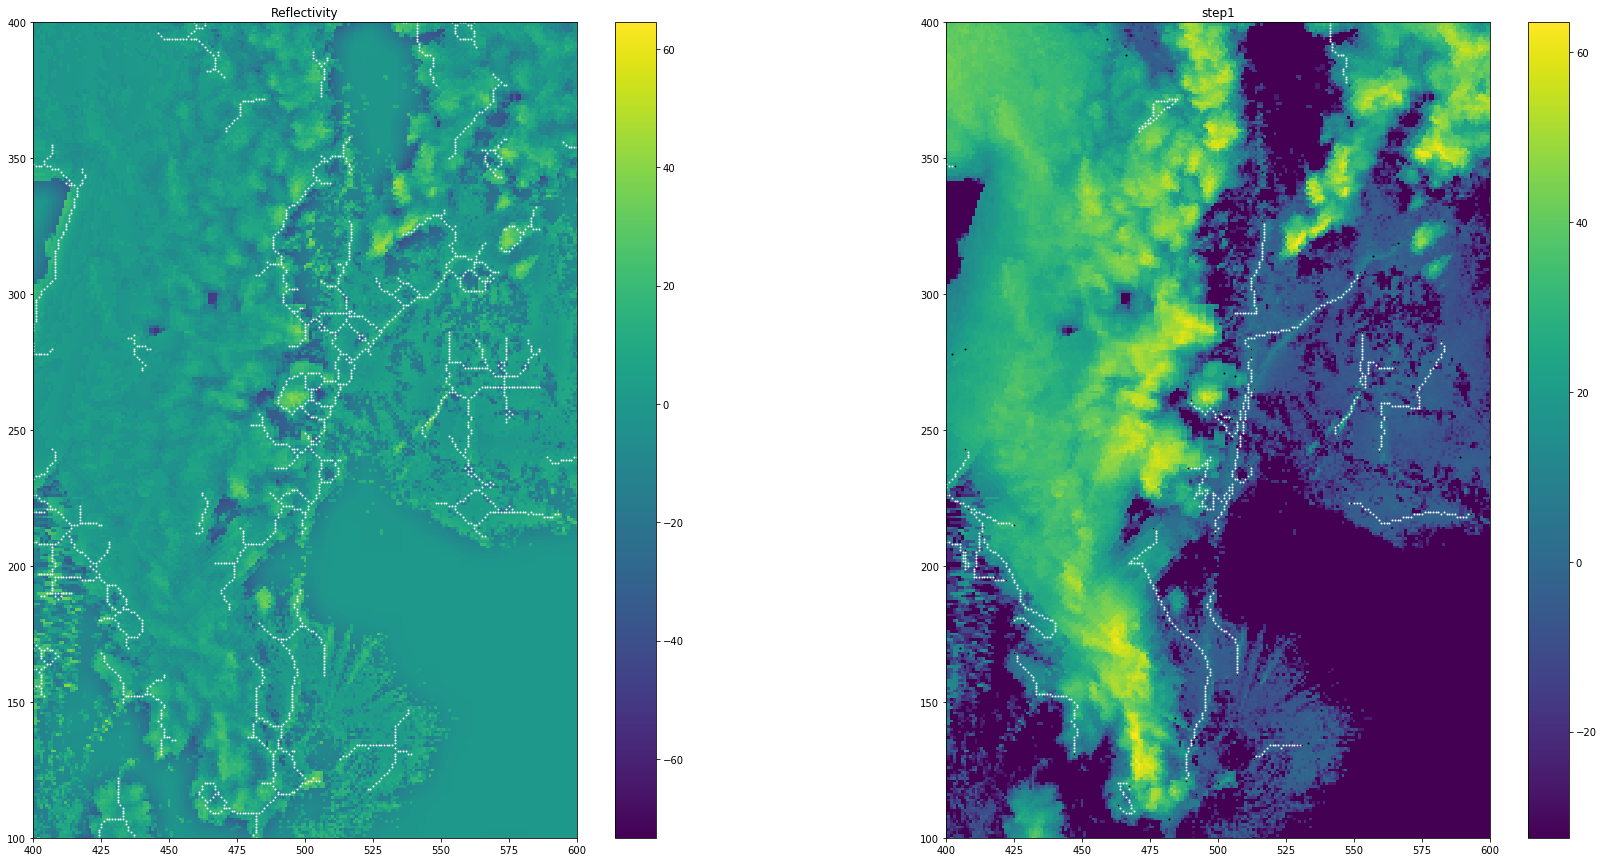

In [10]:
worker(5)

In [131]:
fig = plt.figure(figsize=(30, 15))

ani_object = ani.FuncAnimation(fig, worker, frames=10)

#Save animation to gif
anim_name = 'dbzh_animation_' + dt.now().strftime('%H%M%S') +'.gif'
ani_object.save(anim_name,
          writer='imagemagick', fps=5)
plt.close()
#show gif in notebook
print('complete')
HTML('<img src="' + anim_name + '">')

complete


In [267]:
def worker_mask(i):

    #extract refl data
    refl_img_full = refl_data[i+200, :,:]

    #crop to valid data
    refl_img_crop = refl_img_full[:, x_start:]

    #discreise reflectivity
    refl_img_maxfilter = ndimage.filters.maximum_filter(refl_img_crop, size=3, cval=pad_value)
    refl_img_int = refl_to_int(refl_img_crop) #offset by 5!

    #valid reflectivity mask
    valid_refl_mask = np.logical_and(refl_img_int>=min_refl, refl_img_int<=max_refl)

    #g1 and g2 convolution filers filter
    conv_g1    = ndimage.uniform_filter(refl_img_crop, size=g1_size, mode='constant', cval=pad_value)
    conv_g2    = ndimage.uniform_filter(refl_img_crop, size=g2_size, mode='constant', cval=pad_value)

    #foreground mask
    
    ##############################
    #look at https://scikit-image.org/docs/dev/auto_examples/edges/plot_ridge_filter.html?highlight=ridge%20operators
    ###############################
    
    
    
    
    diff_map                   = refl_img_crop - conv_g2
    diff_map[diff_map<0] = 0
#     ridges_map[ridges_map<0]     = 0
#     ridges_map[~valid_refl_mask] = 0
#     ridges_mask       = np.logical_and(ridges_map>0, valid_refl_mask)

    ridges_map,_ = detect_ridges(diff_map, sigma=1)
    ridges_map[ridges_map<0] = 0
    ridges_mask = ridges_map>5
    #smooth ridge edges to remove burrs using dilation using a 3x3 filter
    ridges_mask_close = morphology.binary_closing(ridges_mask, np.ones((3,3), np.uint8))
    ridges_mask_smooth = morphology.binary_dilation(ridges_mask_close, np.ones((3,3), np.uint8))

    #create narrow bands
    skeleton = morphology.thin(ridges_mask)

    
    #plotting
    plt.clf()
    fig = plt.figure(facecolor='white', figsize=(30, 15))

    zoom = True
    zoom_x = [400, 600]
    zoom_y = [100, 400]
    makersize = 2

    ax0 = plt.subplot(1,2,1)

    im0 = ax0.imshow(diff_map.astype('float'))
    #[line_i, line_j] = np.where(skeleton)
    #ax0.plot(line_j, line_i, 'w.', markersize=makersize)
    ax0.set_title('Reflectivity')
    fig.colorbar(im0, ax=ax0)
    if zoom:
        ax0.set_ylim(zoom_y)
        ax0.set_xlim(zoom_x)

    ax1 = plt.subplot(1,2,2)
    im1 = ax1.imshow(ridges_map.astype('float'))
    ax1.set_title('step1')
    fig.colorbar(im1, ax=ax1)
    if zoom:
        ax1.set_ylim(zoom_y)
        ax1.set_xlim(zoom_x)

<Figure size 432x288 with 0 Axes>

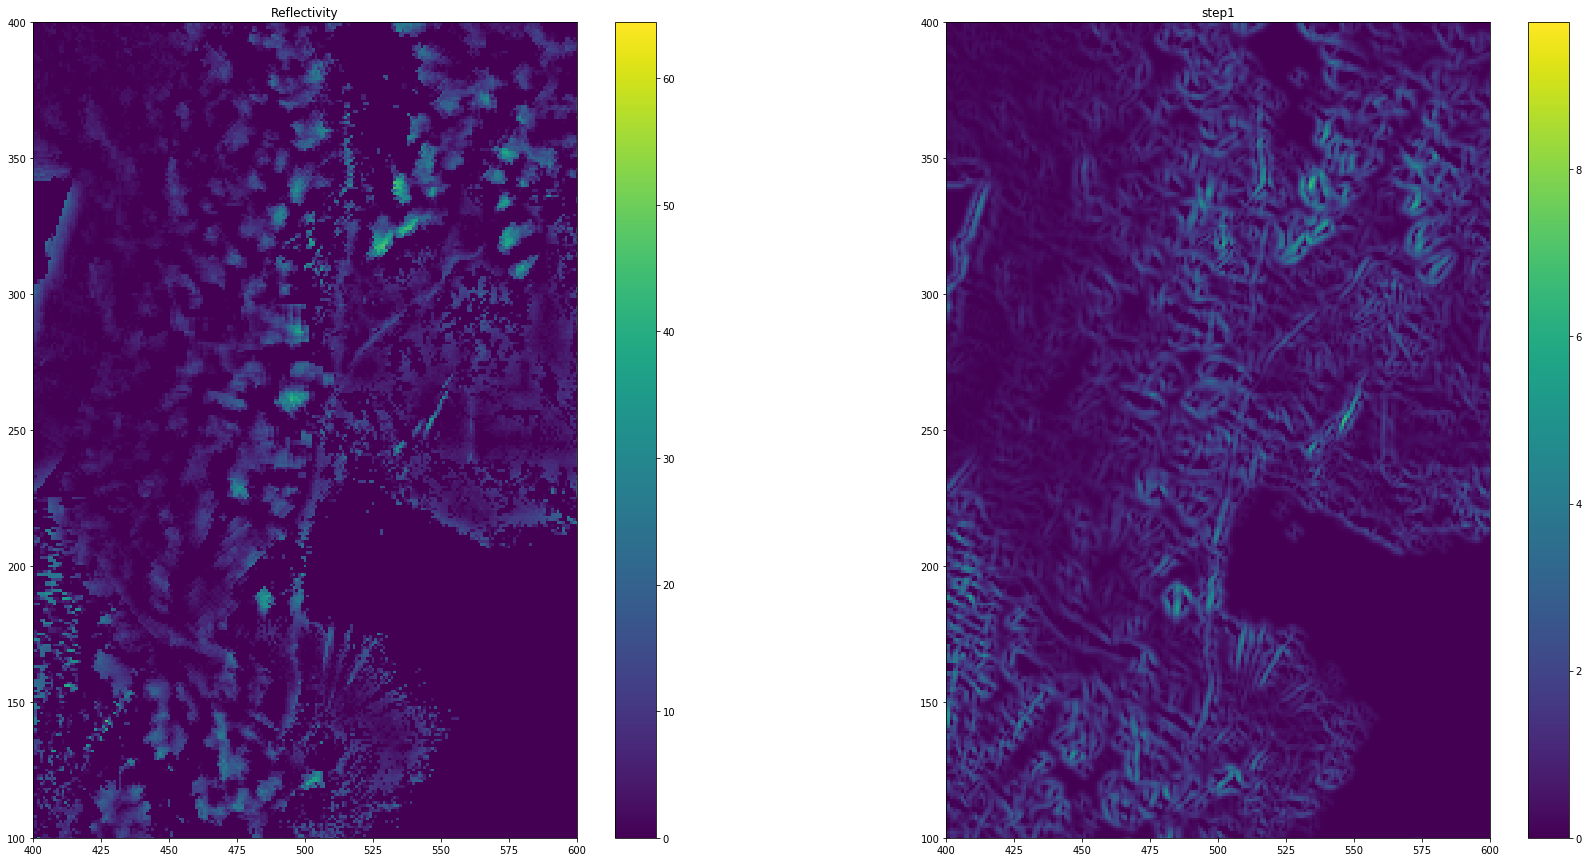

In [268]:
worker_mask(5)